# Final Project - Large Language Models WiSe24/25

Jennifer Coutinho Goncalves | 1001682

# 1. Training Objective

Our goal is to fine-tune a pre-trained Large Language Model (i.e. DistilBERT) for text classification. Specifically, the model will be trained to classify news articles into four categories (World, Sports, Business, Sci/Tech) based on their textual content.

# 2. Research Question

How effectively can a fine-tuned Large Language Model (e.g., DistilBERT) classify news article headlines into categories, and what factors influence its performance?

In [ ]:
# install locally if not using Kaggle

# !pip install transformers torch datasets scikit-learn

# 3. Loading and Exploring the Dataset

In [1]:
# annotated data set for training objective

from datasets import load_dataset

# load AG news dataset from hugging face 
dataset = load_dataset("ag_news")

# print dataset overview to check if successful loading
# overview dataset
print(dataset)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


→ training samples: 120.000

→ test samples: 7.600

In [2]:
import pandas as pd

# convert training dataset to panda dataframe 
df_train = pd.DataFrame(dataset["train"])

# check dataframe
# overview how dataset looks like
print(df_train.head())

                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2


In [3]:
# count occurrences of each label in training dataset
label_counts = df_train["label"].value_counts()

# print label distribution
print("Label distribution in training data:")
print(label_counts)

Label distribution in training data:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64


→ training dataset is perfectly balance (30.000 examples per class)

In [4]:
# NOTE: I did not analyze/visualize the test dataset as much as the training dataset  
# as the project guidelines just asked for the training data

df_test = pd.DataFrame(dataset["test"])

# count occurrences of each label (test dataset)
label_counts = df_test["label"].value_counts()

# print label distribution
print("Label distribution in test data:")
print(label_counts)

Label distribution in test data:
label
2    1900
3    1900
1    1900
0    1900
Name: count, dtype: int64


→ test dataset is perfectly balance (1.900 examples per class)

In [5]:
# show also label name instead of only label -> better overview 
# define category names
label_names = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# map labels to their names
df_train["label_name"] = df_train["label"].map(label_names)

# check if mapping worked
print(df_train.head())

                                                text  label label_name
0  Wall St. Bears Claw Back Into the Black (Reute...      2   Business
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2   Business
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2   Business
3  Iraq Halts Oil Exports from Main Southern Pipe...      2   Business
4  Oil prices soar to all-time record, posing new...      2   Business


→ three entries: text, label, label_name

## 3.1. Data Visualization

In [6]:
# data visualization, show one example text for each category

print("Example texts from each category:\n")

for label in label_names:
    print("Category:", label_names[label])
    print()

    example = df_train[df_train["label"] == label]["text"].sample(1, random_state=42).iloc[0]

    print("  -", example)
    print("\n" + "-" * 92)

Example texts from each category:

Category: World

  - Explosion Rocks Baghdad Neighborhood BAGHDAD, Iraq, August 24 -- A car bomb exploded near the gate of a US-funded Iraqi television network in Baghdad on Tuesday, killing at least two people and wounding two others, authorities and witnesses said.

--------------------------------------------------------------------------------------------
Category: Sports

  - Second Andre win in a row boosts US gold medal hopes Andre Dirrell, fighting with a tattoo of his grandfather #39;s face on his back, assured the United States of at least two boxing medals Wednesday by narrowly beating Cuba #39;s Yordani Despaigne to advance to the Olympic middleweight semifinals.

--------------------------------------------------------------------------------------------
Category: Business

  - US house sales fall in July Sales of non-new houses in the US fell last month but still exceeded analyst forecasts.

----------------------------------------------

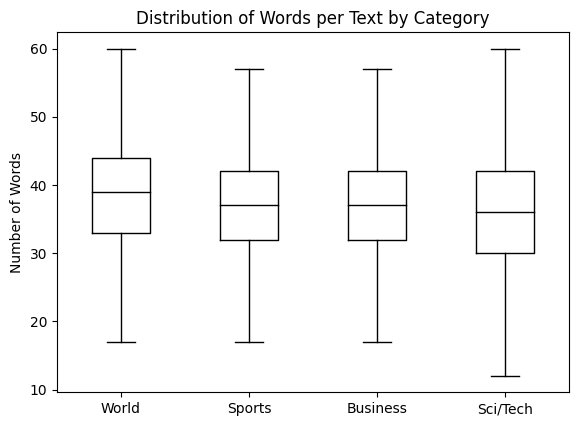

In [7]:
# data visualization, check distribution of words per text/title by category

import matplotlib.pyplot as plt

# compute words per title
df_train["words_per_text"] = df_train["text"].str.split().apply(len)

# define category order 
category_order = ["World", "Sports", "Business", "Sci/Tech"]
df_train["label_name"] = pd.Categorical(df_train["label_name"], categories=category_order, ordered=True)

df_train.boxplot(column="words_per_text", by="label_name", grid=False, showfliers=False, color="black")

plt.suptitle("")
plt.xlabel("")
plt.ylabel("Number of Words")
plt.title("Distribution of Words per Text by Category")

# display boxplot
plt.show()

From the plot can be seen that for each news category (World, Sports, Business, Sci/Tech), the majority of texts contain around 30–40 words. The distributions across categories are fairly similar, with the longest texts reaching around 60 words. Since all texts fall well within the typical context length of transformer-based models like DistilBERT, truncation is unlikely to be an issue. This suggests that the model can process the full text without losing crucial information, and text length alone is not a major factor affecting classification performance.

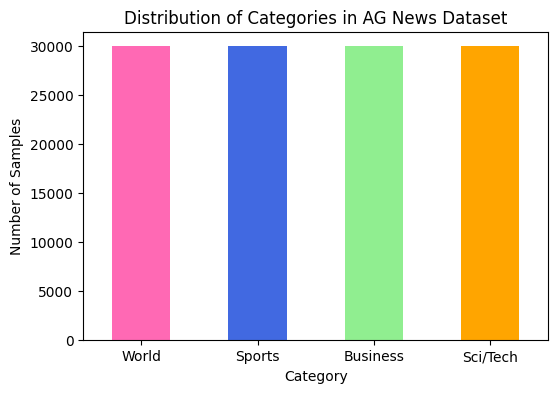

In [8]:
# data visualization, check distribution of categories

# define order of categories (0,1,2,3)
sorted_labels = ["World", "Sports", "Business", "Sci/Tech"]

# define custom colours for each bar 
colors = ["#FF69B4", "#4169E1", "#90EE90", "#FFA500"]

# create bar chart with costum colours
plt.figure(figsize=(6,4))
df_train["label_name"].value_counts()[sorted_labels].plot(kind="bar", color=colors)

# axis lables and title
plt.xlabel("Category")
plt.ylabel("Number of Samples")
plt.title("Distribution of Categories in AG News Dataset")
plt.xticks(rotation=0)

# display chart
plt.show()

## 3.2. AG News Dataset - Explanation

The AG News dataset is a text classification dataset containing news article headlines categorized into four distinct classes:

- World (Label 0) 
- Sports (Label 1) 
- Business (Label 2) 
- Sci/Tech (Label 3)

This dataset is derived from AG, a collection of more than 1 million news articles gathered from over 2000 news sources (for more details, see: http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html). It was constructed by Xiang Zhang (xiang.zhang@nyu.edu) and is widely used as a benchmark for text classification tasks.

The AG News dataset consists of 120.000 training samples and 7.600 test samples, with each category being perfectly balanced (30.000 training examples per class).  

Each entry in the dataset contains of:
- the headline of a news article, serving as input for the model ("text")
- a numerical category (0-3) representing one of the four predefined news topics ("label)
- the corresponding human-readable category name, mapped from the numeric label ("label_name"; manually added for clarity)

As shown in the visualization, the dataset is balanced, meaning all categories have the same number of samples. This ensures that the model is not biased toward any particular class, making it an ideal benchmark for text classification tasks. Furthermore, the texts in all categories are similarly distributed, with most containing 30–40 words and a maximum of around 60. Since this fits within DistilBERT’s context size, truncation is not an issue, ensuring the full text is utilized for classification.

**Citation**

Zhang, Xiang, Junbo Zhao & Yann LeCun. 2015. Character-level convolutional networks for text classification. *Advances in neural information processing systems* 28. 

# 4. Preprocessing the Dataset

In [9]:
# import libraries
from transformers import DistilBertTokenizer

# load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
# function to tokenize
def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

In [11]:
from datasets import Dataset

# convert panda datafram into hugging face dataset format
train_dataset = Dataset.from_pandas(df_train)
df_test = pd.DataFrame(dataset["test"])
test_dataset = Dataset.from_pandas(df_test)

# check dataset structure
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'label', 'label_name', 'words_per_text'],
    num_rows: 120000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 7600
})


In [12]:
# tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [13]:
# keep tokenized input, remove text column and rename labels
train_dataset = train_dataset.remove_columns(["text", "label_name"]).rename_column("label", "labels")
test_dataset = test_dataset.remove_columns(["text"]).rename_column("label", "labels")

In [14]:
# convert dataset to pytorch tensors
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [15]:
# tokenization, check print example to check the format
print(train_dataset[0])

{'labels': tensor(2), 'input_ids': tensor([  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,  1996,  2304,
         1006, 26665,  1007, 26665,  1011,  2460,  1011, 19041,  1010,  2813,
         2395,  1005,  1055,  1040, 11101,  2989,  1032,  2316,  1997, 11087,
         1011, 22330,  8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

→ tokenization successful

# 5. Fine-tuning 

In [16]:
# load the model 

from transformers import DistilBertForSequenceClassification

# load DistilBERT model with classification head
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
        num_labels=4)          # four classes: world, sport, business, sci/tech

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
import torch

# check if GPU is available and move model to right device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

print(f"Device used: {device}")

Device used: cuda


In [18]:
from torch.optim import AdamW
from transformers import get_scheduler

# define optimizer; with weight decay for better generalization
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# define learning rate scheduler
num_training_steps = len(train_dataset) // 64 * 2        # batch size = 64, 2 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [19]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# define performance metrics 
def compute_metrics(pred):
    labels = pred.label_ids  
    preds = pred.predictions.argmax(-1)  
    f1 = f1_score(labels, preds, average="weighted")  
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1} 

In [20]:
from transformers import TrainingArguments
import os

#os.environ["WANDB_DISABLED"] = "true"

# training parameters
batch_size = 64  
logging_steps = len(df_train) // batch_size 
model_name = "distilbert-ag-news"

training_args = TrainingArguments(
    output_dir=model_name,  
    num_train_epochs=2,                            # standard for fine-tuning
    learning_rate=2e-5,  
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size,  
    weight_decay=0.01,                             # prevent overfitting
    eval_strategy="epoch",  
    disable_tqdm=False,  
    logging_steps=logging_steps,  
    push_to_hub=False,  
    log_level="error",
    report_to="none")

In [21]:
from transformers import Trainer

# fine-tune model with hugging face trainer
trainer = Trainer(
    model=model, 
    args=training_args, 
    compute_metrics=compute_metrics,  
    train_dataset=train_dataset,  
    eval_dataset=test_dataset)

In [22]:
# start training
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.188354,0.936184,0.936254
2,0.205200,0.171303,0.941974,0.942001


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=1876, training_loss=0.20518090912718762, metrics={'train_runtime': 5790.3451, 'train_samples_per_second': 41.448, 'train_steps_per_second': 0.324, 'total_flos': 3.179330961408e+16, 'train_loss': 0.20518090912718762, 'epoch': 2.0})

In [23]:
# evaluate model
results = trainer.evaluate()

# display resuls
print("Evaluation Results:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results:
eval_loss: 0.1713
eval_accuracy: 0.9420
eval_f1: 0.9420
eval_runtime: 62.9065
eval_samples_per_second: 120.8140
eval_steps_per_second: 0.9540
epoch: 2.0000


## 5.1. Results

The decrease in validation loss during the second epoch indicates that the model is still learning and improving with each iteration. This trend suggests that the model is effectively adapting to the task. 

The fact that the training loss remains only slightly higher than the validation loss suggests that there is no overfitting. 

Additionally, the accuracy of 94.2% suggests that the model is performing at a high level in classifying the category labels. The F1-score of 94.2% further confirms that the model has learned meaningful patterns and generalizes effectively to unseen data. 

## 5.2. Comparison to Baseline Classifier

In [24]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(dataset["train"]["text"])
X_test = vectorizer.transform(dataset["test"]["text"])

# train and evaluate dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, dataset["train"]["label"])
accuracy = dummy_clf.score(X_test, dataset["test"]["label"])

# display accuracy
print(f"Dummy Accuracy: {accuracy:.4f}")

Dummy Accuracy: 0.2500


### Results of Comparison to Baseline Classifier

To assess the effectiveness of our fine-tuned model, we compared it to a Dummy Classifier using the most frequent class strategy. As expected, the baseline classifier achieved an accuracy of 25%, which corresponds to random chance in a four-class problem.

In contrast, the DistilBERT model achieved 94.2% accuracy, showing a substantial improvement. This confirms that the model successfully learns meaningful patterns rather than relying on class distribution.

The comparison highlights the model’s effectiveness and justifies its use over a naive classification approach. Moving forward, further error analysis could help identify potential areas for improvement.

## 5.3. Results Visualization

In [25]:
# get predictions on test dataset to calculate confusion matrix

# get predictions on test dataset
preds_output = trainer.predict(test_dataset)

# get metrics on the test dataset
print(preds_output.metrics)

y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = np.array(test_dataset["labels"])

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'test_loss': 0.17130348086357117, 'test_accuracy': 0.9419736842105263, 'test_f1': 0.942001144416451, 'test_runtime': 62.3462, 'test_samples_per_second': 121.9, 'test_steps_per_second': 0.962}


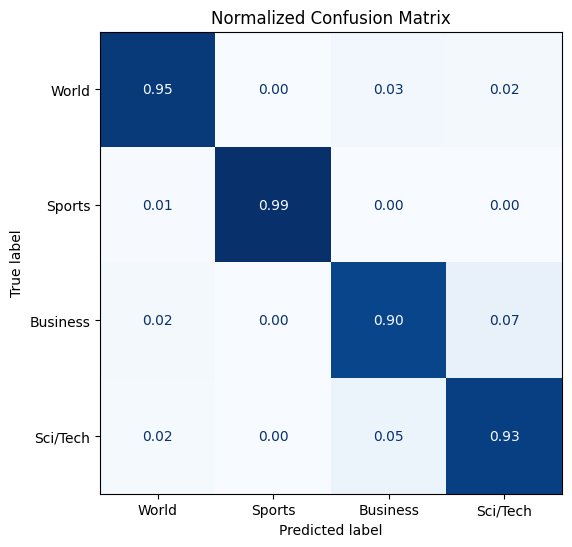

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# function to plot confusion matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

# define category labels 
labels = ["World", "Sports", "Business", "Sci/Tech"]

# plot confusion matrix
plot_confusion_matrix(y_preds, y_true, labels)

### Interpretation of Confusion Matrix 

The confusion matrix shows that the model performs at a high level in distinguishing between the four news categories. However, some misclassifications still occur. 

- **World**: 95% correctly classified
              → 3% misclassified as Business; 2 % misclassified as Sci/Tech
  
- **Sports**: 99% correctly classified
              → 1% misclassified as World
  
- **Business**: 90% correctly classified
              → 2% misclassified as World; 7% misclassified as Sci/Tech

- **Sci/Tech**: 93% correctly classified
              → 2% misclassified as World; 5% misclassified as Business

The model is highly reliable in classifying World and Sports news, with minimal misclassifications. However, there is noticeable confusion between Business and Sci/Tech categories: 7% of Business news is misclassified as Sci/Tech and 5% of Sci/Tech news is misclassified as Business. This suggests that some headlines in these categories share similar wording or topics, leading to occasional errors.

# 6. Error analysis 

The results highlight the model’s strong classification performance, with an accuracy of over 90%. However, the confusion matrix reveals that misclassifications occur, particularly between the Business and Sci/Tech categories. Therefore, analyzing these errors is essential to identify potential areas for improvement and better understand the model's limitations.

In [27]:
# load same tokenizer as used during training
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# reconstruct original text; skip special tokens
texts = tokenizer.batch_decode(test_dataset["input_ids"], skip_special_tokens=True)

In [28]:
# create dataframe containing reconstructed text, true labels and predictions
df_preds = pd.DataFrame({
    "text": texts,
    "true_label": y_true,
    "predicted_label": y_preds
})

In [29]:
# define mapping from label IDs to category names
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# map lable IDs to category names
df_preds["true_label_name"] = df_preds["true_label"].map(label_map)
df_preds["predicted_label_name"] = df_preds["predicted_label"].map(label_map)

# misclassfied examples only
df_misclassified = df_preds[df_preds["true_label"] != df_preds["predicted_label"]]

In [30]:
from IPython.display import display  

# business headlines that were misclassified as sci/tech
df_business_to_sci = df_misclassified[
    (df_misclassified["true_label_name"] == "Business") & (df_misclassified["predicted_label_name"] == "Sci/Tech")
]

# sci/Tech articles that were misclassified as business
df_sci_to_business = df_misclassified[
    (df_misclassified["true_label_name"] == "Sci/Tech") & (df_misclassified["predicted_label_name"] == "Business")
]

In [31]:
# display misclassified business headlines
print("Business article headlines misclassified as Sci/Tech:")
display(df_business_to_sci[["text", "true_label_name", "predicted_label_name"]].sample(10, random_state=42))

# display misclassified sci/tech headlines
print("Sci/Tech article headlines misclassified as Business:")
display(df_sci_to_business[["text", "true_label_name", "predicted_label_name"]].sample(10, random_state=42))

Business article headlines misclassified as Sci/Tech:


,text,true_label_name,predicted_label_name
3968,us consumers unaware of spyware the findings c...,Business,Sci/Tech
2451,"ca, partners move on as kumar faces charges co...",Business,Sci/Tech
3170,feds kick off digital tv consumer campaign was...,Business,Sci/Tech
2333,rumours surround google browser the search gia...,Business,Sci/Tech
7051,amazon # 39 ; s uk dvd rentals might presage w...,Business,Sci/Tech
3264,ca aquires computer security firm computer ass...,Business,Sci/Tech
835,us bells do video on path blazed by small telc...,Business,Sci/Tech
4591,cingular closes # 36 ; 41 bln att wireless dea...,Business,Sci/Tech
1291,drug makers target counterfeits big pharmaceut...,Business,Sci/Tech
3334,34 tech firms sued for alleged lcd patent thef...,Business,Sci/Tech


Sci/Tech article headlines misclassified as Business:


,text,true_label_name,predicted_label_name
2145,a # 39 ; plan b # 39 ; for peoplesoft customer...,Sci/Tech,Business
4441,approval expected for big cellphone deal feder...,Sci/Tech,Business
4097,"greenspan : debt, home prices not dangerous th...",Sci/Tech,Business
3060,"you have mail, always, with a blackberry washi...",Sci/Tech,Business
2848,"pharma groups work on epc issues sept. 30, 200...",Sci/Tech,Business
2806,immunity in ebbers case opposed in u. s. filin...,Sci/Tech,Business
6320,cingular to reduce work force by roughly 10 pe...,Sci/Tech,Business
2982,gates : us need not fear overseas tech the uni...,Sci/Tech,Business
664,tivo loss widens san francisco ( cbs. mw ) - t...,Sci/Tech,Business
20,ibm to hire even more new workers by the end o...,Sci/Tech,Business


Regarding the Business headlines that were misclassified as Sci/Tech, we can observe that many contain technology-related terms such as "google", "amazon", "computer", "spyware".

Similarly, when looking at Sci/Tech headlines misclassified as Business, we find words that are typically associated with business contexts, such as "plan B", "costumer", "workers", "debt".

These findings suggest that the model relies on specific keywords rather than understanding the full contextual meaning of the headlines.

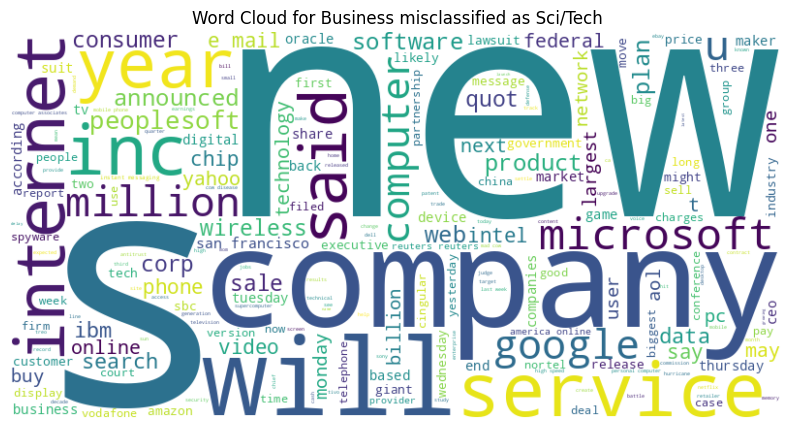

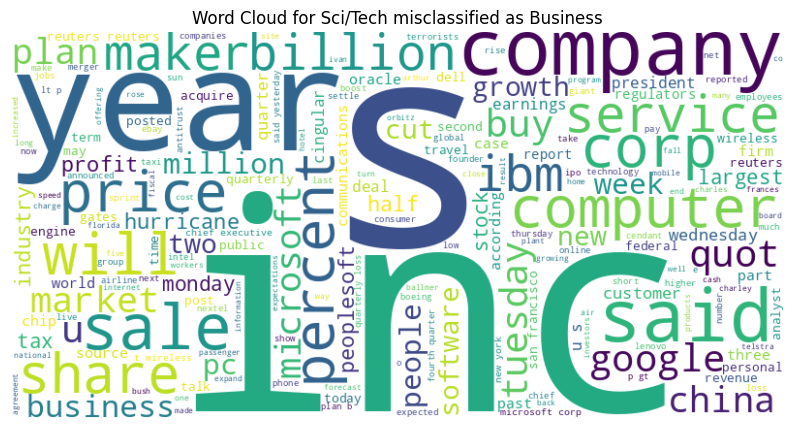

In [32]:
# this code is inspired by the kaggle notebook: 
# https://www.kaggle.com/code/edumisvieramartin/news-multi-class-classification-nlp-91-acc

from wordcloud import WordCloud

# function to generate word cloud 
def generate_word_cloud(data, title):
    text = " ".join(data["text"])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# wordcloud for misclassified business headlines
generate_word_cloud(df_business_to_sci, "Word Cloud for Business misclassified as Sci/Tech")

# wordcloud for misclassified sci/tech headlines
generate_word_cloud(df_sci_to_business, "Word Cloud for Sci/Tech misclassified as Business")


Word clouds represent the most frequently words in the text visually, with larger words indicating higher frequency.

Comparing the word clouds for Business misclassified as Sci/Tech and Sci/Tech misclassified as Business, we can observe some key differences. In the Business → Sci/Tech misclassifications, many technology-related terms appear, such as "online", "web", "software", "computer", and "internet" along with major tech companies like "microsoft", "ibm", and "google".

Similarly, in the Sci/Tech → Business misclassifications, we also see tech-related terms and companies, including "microsoft" "software" "computer" and others. However, there is a noticeable overlap between the two categories, with shared words like "computer", "software", "microsoft", "ibm", "google" as well as more general terms such as "company", "said", "inc", and "service"

These findings reinforce the idea that the model relies heavily on individual words rather than fully understanding the context of the headlines, leading to frequent misclassifications between these two categories.

## 6.1. Results Error Analysis

The error analysis suggests that the model relies heavily on individual words rather than understanding the full context of headlines, leading to frequent misclassifications between Business and Sci/Tech. Business headlines containing technology-related terms were often misclassified as Sci/Tech, while Sci/Tech headlines with business-related words were mislabeled as Business. The word cloud analysis further highlights significant vocabulary overlap, reinforcing the model’s reliance on keywords rather than meaning. Additionally, the overlap between Business and Sci/Tech topics, such as corporate developments in the tech industry, likely contributes to confusion. This suggests that contextual understanding needs improvement, potentially by incorporating better text representations or additional training data.

# 7. Optimization 

Even though the model already achieved high accuracy, there is still room for optimization. Several approaches could be explored to further improve the model and its performance.

## 7.1. Tokenization

During tokenization, a maximum sequence length of 512 tokens was applied, which corresponds to the upper limit supported by the DistilBERT model. However, it might have been beneficial to first analyze the token lengths and then select a more suitable sequence length based on the data. Using a shorter maximum sequence length could potentially reduce training time, which in this case was approximately 1.5 hours.

Initial data exploration revealed that the headlines are relatively short, typically containing around 30 to 40 words. To assess whether a lower sequence length would have sufficed, the number of tokens per headline will now be examined.

In [33]:
# tokenize texts and compute lengths
texts = dataset["train"]["text"]
token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in texts]

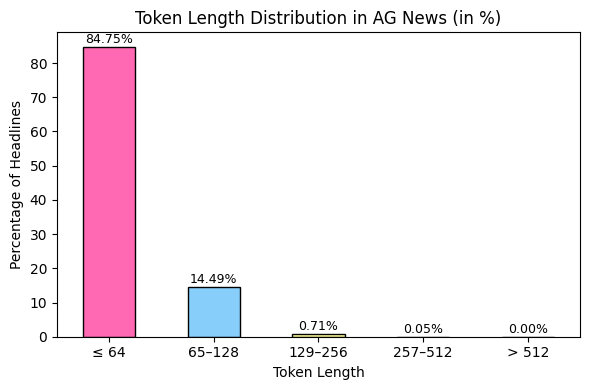

In [34]:
# define token length categories
tokens = {
    "≤ 64": sum(l <= 64 for l in token_lengths),
    "65–128": sum(64 < l <= 128 for l in token_lengths),
    "129–256": sum(128 < l <= 256 for l in token_lengths),
    "257–512": sum(256 < l <= 512 for l in token_lengths),
    "> 512": sum(l > 512 for l in token_lengths)  # usually 0 for DistilBERT
}

# convert to dataframe
df_tokens = pd.DataFrame.from_dict(tokens, orient='index', columns=["count"])

# percentage column
df_tokens["percent"] = (df_tokens["count"] / df_tokens["count"].sum()) * 100

# define custom colours 
colors = ["#FF69B4", "#87CEFA", "#FFFF99", "#FFD580", "#90EE90"]

# plot bar chart with percentages
plt.figure(figsize=(6, 4))
ax = df_tokens["percent"].plot(kind="bar", color=colors, edgecolor="black")

# axis labels and chart title
plt.xlabel("Token Length")
plt.ylabel("Percentage of Headlines")
plt.title("Token Length Distribution in AG News (in %)")

# show percentage values above bars
for i, value in enumerate(df_tokens["percent"]):
    ax.text(i, value + 0.3, f"{value:.2f}%", ha='center', va='bottom', fontsize=9)

# display chart
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Based on the token length distribution, a maximum sequence length of 128 would have been sufficient, as less than 1% of the samples exceed this limit.

In [35]:
# try maximum sequence length of 128 

# import libraries
from transformers import DistilBertTokenizer

# load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [36]:
# function to tokenize
def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

In [37]:
from datasets import Dataset

# convert panda datafram into hugging face dataset format
train_dataset = Dataset.from_pandas(df_train)
df_test = pd.DataFrame(dataset["test"])
test_dataset = Dataset.from_pandas(df_test)

# check dataset structure
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'label', 'label_name', 'words_per_text'],
    num_rows: 120000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 7600
})


In [38]:
# tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [39]:
# keep tokenized input, remove text column and rename labels
train_dataset = train_dataset.remove_columns(["text", "label_name"]).rename_column("label", "labels")
test_dataset = test_dataset.remove_columns(["text"]).rename_column("label", "labels")

In [40]:
# convert dataset to pytorch tensors
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [41]:
# tokenization, check print example to check the format
print(train_dataset[0])

{'labels': tensor(2), 'input_ids': tensor([  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,  1996,  2304,
         1006, 26665,  1007, 26665,  1011,  2460,  1011, 19041,  1010,  2813,
         2395,  1005,  1055,  1040, 11101,  2989,  1032,  2316,  1997, 11087,
         1011, 22330,  8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [42]:
# load the model 

from transformers import DistilBertForSequenceClassification

# load DistilBERT model with classification head
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
        num_labels=4)          # four classes: world, sport, business, sci/tech

In [43]:
import torch

# check if GPU is available and move model to right device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

print(f"Device used: {device}")

Device used: cuda


In [44]:
from torch.optim import AdamW
from transformers import get_scheduler

# define optimizer; with weight decay for better generalization
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# define learning rate scheduler
num_training_steps = len(train_dataset) // 64 * 2  
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [45]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# define performance metrics 
def compute_metrics(pred):
    labels = pred.label_ids  
    preds = pred.predictions.argmax(-1)  
    f1 = f1_score(labels, preds, average="weighted")  
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1} 

In [46]:
from transformers import TrainingArguments
import os

#os.environ["WANDB_DISABLED"] = "true"

# training parameters
batch_size = 64  
logging_steps = len(df_train) // batch_size 
model_name = "distilbert-ag-news"

training_args = TrainingArguments(
    output_dir=model_name,  
    num_train_epochs=2,                            # standard for fine-tuning
    learning_rate=2e-5,  
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size,  
    weight_decay=0.01,                             # prevent overfitting
    eval_strategy="epoch",  
    disable_tqdm=False,  
    logging_steps=logging_steps,  
    push_to_hub=False,  
    log_level="error",
    report_to="none")

In [47]:
from transformers import Trainer

# fine-tune model with hugging face trainer
trainer = Trainer(
    model=model, 
    args=training_args, 
    compute_metrics=compute_metrics,  
    train_dataset=train_dataset,  
    eval_dataset=test_dataset)

In [48]:
# start training
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.188406,0.936447,0.936505
2,0.209600,0.175503,0.940000,0.940012


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=1876, training_loss=0.2095792588871171, metrics={'train_runtime': 1377.791, 'train_samples_per_second': 174.192, 'train_steps_per_second': 1.362, 'total_flos': 7948327403520000.0, 'train_loss': 0.2095792588871171, 'epoch': 2.0})

In [49]:
# evaluate model
results = trainer.evaluate()

# display resuls
print("Evaluation Results:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results:
eval_loss: 0.1755
eval_accuracy: 0.9400
eval_f1: 0.9400
eval_runtime: 14.6920
eval_samples_per_second: 517.2880
eval_steps_per_second: 4.0840
epoch: 2.0000


The results are comparable to those obtained using a maximum sequence length of 512 during tokenization. The model trained with a sequence length of 128 achieved an accuracy and F1-score of approximately 94%, only slightly below the 94.2% reached with 512 tokens.
Additionally, the validation loss decreased during the second epoch, and the gap between training and validation loss remained minimal—further confirming that model performance remained stable.

The most notable difference, however, lies in the training time: while training with 512 tokens took around 1.5 hours, the run with 128 tokens completed in just over 20 minutes.
This substantial reduction in training time, combined with nearly identical performance metrics, suggests that a maximum sequence length of 128 would have been sufficient for this task.

## 7.2. Epochs

The model was trained for two epochs, which is a common starting point when fine-tuning transformer models. This allows for an initial evaluation of performance without requiring extensive training time or introducing a high risk of overfitting during early experiments.
To assess whether additional epochs would lead to further improvements, training was also conducted for five epochs.

In [52]:
# change number of epochs to five

training_args = TrainingArguments(
    output_dir=model_name,  
    num_train_epochs=5,                            # standard for fine-tuning
    learning_rate=2e-5,  
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size,  
    weight_decay=0.01,                             # prevent overfitting
    eval_strategy="epoch",  
    disable_tqdm=False,  
    logging_steps=logging_steps,  
    push_to_hub=False,  
    log_level="error",
    report_to="none")

In [53]:
from transformers import Trainer

# fine-tune model with hugging face trainer
trainer = Trainer(
    model=model, 
    args=training_args, 
    compute_metrics=compute_metrics,  
    train_dataset=train_dataset,  
    eval_dataset=test_dataset)  

In [54]:
# start training
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.182442,0.939211,0.939202
2,0.117500,0.178549,0.941184,0.941312
3,0.117500,0.191781,0.941842,0.941934
4,0.070200,0.207507,0.941447,0.941408
5,0.070200,0.219471,0.941974,0.942013


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=4690, training_loss=0.08440563307642174, metrics={'train_runtime': 3438.5538, 'train_samples_per_second': 174.492, 'train_steps_per_second': 1.364, 'total_flos': 1.98708185088e+16, 'train_loss': 0.08440563307642174, 'epoch': 5.0})

The results show that accuracy increased only slightly from 94.18% (after 2 epochs) to 94.2% (after 5 epochs), while the F1-score rose from 94.13% to 94.2%. At the same time, the validation loss increased from 0.1785 to 0.2195, while the training loss continued to decrease. This growing gap between training and validation loss suggests some overfitting, as the model increasingly fitted the training data without improving its performance on unseen data. Therefore, training beyond two epochs did not lead to meaningful improvements and introduced a risk of overfitting. Thus, training the model for two epochs proves to be the most efficient and balanced choice.

## 7.3. Learning Rate

The model was initially fine-tuned using a learning rate of 2e-5, a widely adopted default for transformer-based models. This value provides a stable starting point, allowing the pre-trained weights to adapt gradually to the specific classification task. Additional a learning rates of 1e-5 was tested to evaluate its effect on the model performance.

### 7.3.1. Learning Rate 1e-5

In [55]:
# change learning rate to 1e-5

training_args = TrainingArguments(
    output_dir=model_name,  
    num_train_epochs=2,                            # standard for fine-tuning
    learning_rate=1e-5,  
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size,  
    weight_decay=0.01,                             # prevent overfitting
    eval_strategy="epoch",  
    disable_tqdm=False,  
    logging_steps=logging_steps,  
    push_to_hub=False,  
    log_level="error",
    report_to="none")

In [56]:
from transformers import Trainer

# fine-tune model with hugging face trainer
trainer = Trainer(
    model=model, 
    args=training_args, 
    compute_metrics=compute_metrics,  
    train_dataset=train_dataset,  
    eval_dataset=test_dataset)  

In [57]:
# start training
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.253070,0.936974,0.936983
2,0.026700,0.266448,0.939474,0.939459


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=1876, training_loss=0.026670710615583383, metrics={'train_runtime': 1379.2874, 'train_samples_per_second': 174.003, 'train_steps_per_second': 1.36, 'total_flos': 7948327403520000.0, 'train_loss': 0.026670710615583383, 'epoch': 2.0})

When training the model with a learning rate of 1e-5, performance remained slightly below that of the default 2e-5 configuration. After two epochs, the model reached an accuracy and F1-score of 93.95%, while the validation loss increased from 0.2531 to 0.2664 between the first and second epoch. This suggests that, despite further training, the model did not generalize better and even showed slight signs of overfitting. As a result, this lower learning rate did not improve performance in this setting.

## 7.4. Further Optimization

Although several simple optimization steps were tested, such as adjusting the learning rate, number of epochs, and maximum sequence length, these changes did not lead to a noticeable improvement over the initial setup. To achieve further gains in performance, other strategies could be explored. One possibility would be to experiment with different pre-trained transformer models. While DistilBERT provides efficient results, alternative architectures like BERT and RoBERT may perform better due to their structural differences and larger training corpora. Another approach would be to include more contextual information, as the current model relies solely on headlines. Adding accompanying news descriptions could help disambiguate semantically similar categories such as Business and Sci/Tech. In addition, analyzing class-specific evaluation metrics might provide more detailed insights into model weaknesses and help refine areas where the model requires improvement.

# 8. Overall Interpretation of the Results

The findings demonstrate that a pre-trained transformer model like DistilBERT can be fine-tuned to classify news headlines into four categories with high accuracy. The model achieved strong results with minimal tuning, confirming its ability to generalize from short, structured inputs. While classification was highly reliable for distinct topics such as World and Sports, some confusion arose between Business and Sci/Tech, likely due to overlapping terminology.

Simple optimization attempts, including adjustments to the sequence length, learning rate, and training duration, did not significantly improve performance. However, reducing the maximum sequence length proved to be a practical adjustment, cutting training time substantially without sacrificing accuracy. Overall, the model delivered robust performance and offered valuable insights into the influence of category similarity, token length, and model settings on classification quality.